<a href="https://colab.research.google.com/github/puigruizjosep1/RL_implementations/blob/main/MonteCarlo_Policy_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
__single_deck = sorted([value for value in range(2, 12) for _ in range(4)] + [10]*12)

def codify_state(player_current_sum, up_card_dealer, usable_ace):
    return '{}_{}_{}'.format(str(int(player_current_sum)), str(up_card_dealer), str(usable_ace))


def get_count_and_usable_ace(lst_cards_original):
    lst_cards = [c for c in lst_cards_original]
    sum_11 = sum(lst_cards)
    if sum_11 <= 21:
        return sum_11, 11 in lst_cards, lst_cards
    # If count > 21:
    for i, card in enumerate(lst_cards):
        if card == 11:
            lst_cards[i]=1
            sum_11 -= 10
            if sum_11 <= 21:
                return sum_11, 11 in lst_cards, lst_cards
    return sum_11, 11 in lst_cards, lst_cards

def naive_policy(state):
    count = int(state.split('_')[0])
    return 'stick' if count > 19 else 'hit'





def simulate_BJ_episode():
    lst_SARS = []
    # 1st) Draw cards for player
    player_cards = [random.choice(__single_deck), random.choice(__single_deck)]
    player_count, usable_ace, player_cards = get_count_and_usable_ace(player_cards)
    while player_count < 12:
        player_cards.append(random.choice(__single_deck))
        player_count, usable_ace, player_cards = get_count_and_usable_ace(player_cards)
    # 2nd) Draw card for dealer
    dealer_card = random.choice(__single_deck) # To ensure no data leakage, sampling 2nd card later. Replacement, so it's not important
    dealer_cards = [dealer_card]
    current_state = codify_state(player_current_sum = player_count, up_card_dealer=dealer_card, usable_ace=usable_ace)
    
    episode_done = False
    

    while not episode_done:
        
        # Decide action per policy
        action = naive_policy(current_state)
        #print('State = {}, action={}'.format(current_state, action))
        if action == 'hit':
            #print('Action = HIT for player_cards = {}'.format(player_cards))
            player_cards.append(random.choice(__single_deck))
            player_count, usable_ace, player_cards = get_count_and_usable_ace(player_cards)
            new_state = codify_state(player_current_sum = player_count, up_card_dealer=dealer_card, usable_ace=usable_ace)
            if player_count > 21:
                episode_done = True
                reward = -1
                
            else:
                reward = 0



            # UPDATE STATE! current_state = new_state
        elif action == 'stick':
            #print('Action = STICK for player_cards = {}'.format(player_cards))
            episode_done = True
            # Simulate game for dealer
            
            new_state = 'NAN'
            dealer_done = False
            while not dealer_done:
                dealer_count, _, dealer_cards = get_count_and_usable_ace(dealer_cards)
                if dealer_count >= 17:
                    dealer_done = True
                else:
                    dealer_cards.append(random.choice(__single_deck))

            if dealer_count > 21:
                reward = 1
            else:
                reward = 1 if player_count > dealer_count else (0 if player_count == dealer_count else -1) 

        lst_SARS.append([current_state, action, reward, new_state, True, player_cards.copy(), dealer_cards]) 
        if not episode_done:
            current_state = new_state
    #print('Dealer cards = {}'.format(dealer_cards))
    return lst_SARS

In [85]:
for _ in range(50):
    lst_SARS = simulate_BJ_episode()
    
    print(lst_SARS)


[['13_5_False', 'hit', -1, '23_5_False', True, [8, 5, 10], [5]]]
[['20_6_False', 'stick', 1, 'NAN', True, [10, 10], [6, 9, 7]]]
[['20_3_True', 'stick', -1, 'NAN', True, [11, 9], [3, 9, 9]]]
[['16_10_False', 'hit', 0, '20_10_False', True, [7, 9, 4], [10]], ['20_10_False', 'stick', -1, 'NAN', True, [7, 9, 4], [10, 3, 8]]]
[['20_7_False', 'stick', 1, 'NAN', True, [10, 10], [7, 2, 10]]]
[['21_9_True', 'stick', 1, 'NAN', True, [11, 10], [9, 2, 8]]]
[['20_3_False', 'stick', -1, 'NAN', True, [10, 10], [3, 3, 5, 10]]]
[['18_10_False', 'stick', 0, 'NAN', True, [9, 9], [10, 8]]]
[['16_10_False', 'hit', -1, '26_10_False', True, [8, 8, 10], [10]]]
[['19_9_False', 'stick', -1, 'NAN', True, [10, 9], [9, 11]]]
[['21_9_False', 'stick', 1, 'NAN', True, [4, 5, 2, 10], [9, 5, 6]]]
[['21_6_True', 'stick', 1, 'NAN', True, [10, 11], [6, 5, 7]]]
[['15_2_False', 'hit', -1, '22_2_False', True, [5, 10, 7], [2]]]
[['17_4_False', 'hit', 0, '19_4_False', True, [5, 6, 6, 2], [4]], ['19_4_False', 'stick', -1, 'NAN',

In [2]:
## FIRST-VISIT MONTE-CARLO SCHEME for POLICY EVALUATION

lst_states = [codify_state(a, b, c) for a in range(12, 22) for b in range(2, 12) for c in [True, False]]

V = {s: 0 for s in lst_states}

returns = {s: [] for s in lst_states}

end_condition = False
gamma = 1.0
count_episodes = 1
N_episodes = 500000
while not end_condition:
    # New episode
    episode = simulate_BJ_episode() # TODO save as tuples [S, A, R, S_next, first_visit] --> LIST OF LISTS
    if count_episodes % 1000 == 0:
        print('Episode {}'.format(count_episodes))
    #print('Episode number {}, {}'.format(count_episodes+1, episode))
    return_episode = 0

    count_episodes += 1
    if count_episodes > N_episodes:
        end_condition = True

    for S, A, R, S_next, first_visit, _, _ in episode[::-1]: # Backwards(!)
        
        return_episode = gamma*return_episode + R
        if first_visit:
            returns[S].append(return_episode)
            V[S] = sum(returns[S])/len(returns[S])



Episode 1000
Episode 2000
Episode 3000
Episode 4000
Episode 5000
Episode 6000
Episode 7000
Episode 8000
Episode 9000
Episode 10000
Episode 11000
Episode 12000
Episode 13000
Episode 14000
Episode 15000
Episode 16000
Episode 17000
Episode 18000
Episode 19000
Episode 20000
Episode 21000
Episode 22000
Episode 23000
Episode 24000
Episode 25000
Episode 26000
Episode 27000
Episode 28000
Episode 29000
Episode 30000
Episode 31000
Episode 32000
Episode 33000
Episode 34000
Episode 35000
Episode 36000
Episode 37000
Episode 38000
Episode 39000
Episode 40000
Episode 41000
Episode 42000
Episode 43000
Episode 44000
Episode 45000
Episode 46000
Episode 47000
Episode 48000
Episode 49000
Episode 50000
Episode 51000
Episode 52000
Episode 53000
Episode 54000
Episode 55000
Episode 56000
Episode 57000
Episode 58000
Episode 59000
Episode 60000
Episode 61000
Episode 62000
Episode 63000
Episode 64000
Episode 65000
Episode 66000
Episode 67000
Episode 68000
Episode 69000
Episode 70000
Episode 71000
Episode 72000
E

In [4]:
## OPTIMIZED FIRST-VISIT MONTE-CARLO SCHEME for POLICY EVALUATION

lst_states = [codify_state(a, b, c) for a in range(12, 22) for b in range(2, 12) for c in [True, False]]

V = {s: 0 for s in lst_states}

returns = {s: [0, 0] for s in lst_states} #1st element: sum, 2nd element: count

end_condition = False
gamma = 1.0
count_episodes = 1
N_episodes = 500000
while not end_condition:
    # New episode
    episode = simulate_BJ_episode() # TODO save as tuples [S, A, R, S_next, first_visit] --> LIST OF LISTS
    if count_episodes % 1000 == 0:
        print('Episode {}'.format(count_episodes))
    #print('Episode number {}, {}'.format(count_episodes+1, episode))
    return_episode = 0

    count_episodes += 1
    if count_episodes > N_episodes:
        end_condition = True

    for S, A, R, S_next, first_visit, _, _ in episode[::-1]: # Backwards(!)
        
        return_episode = gamma*return_episode + R
        if first_visit:
            returns[S][0]+=return_episode
            returns[S][1]+=1
            #returns[S].append(return_episode)
            V[S] = returns[S][0]/(returns[S][1])


Episode 1000
Episode 2000
Episode 3000
Episode 4000
Episode 5000
Episode 6000
Episode 7000
Episode 8000
Episode 9000
Episode 10000
Episode 11000
Episode 12000
Episode 13000
Episode 14000
Episode 15000
Episode 16000
Episode 17000
Episode 18000
Episode 19000
Episode 20000
Episode 21000
Episode 22000
Episode 23000
Episode 24000
Episode 25000
Episode 26000
Episode 27000
Episode 28000
Episode 29000
Episode 30000
Episode 31000
Episode 32000
Episode 33000
Episode 34000
Episode 35000
Episode 36000
Episode 37000
Episode 38000
Episode 39000
Episode 40000
Episode 41000
Episode 42000
Episode 43000
Episode 44000
Episode 45000
Episode 46000
Episode 47000
Episode 48000
Episode 49000
Episode 50000
Episode 51000
Episode 52000
Episode 53000
Episode 54000
Episode 55000
Episode 56000
Episode 57000
Episode 58000
Episode 59000
Episode 60000
Episode 61000
Episode 62000
Episode 63000
Episode 64000
Episode 65000
Episode 66000
Episode 67000
Episode 68000
Episode 69000
Episode 70000
Episode 71000
Episode 72000
E

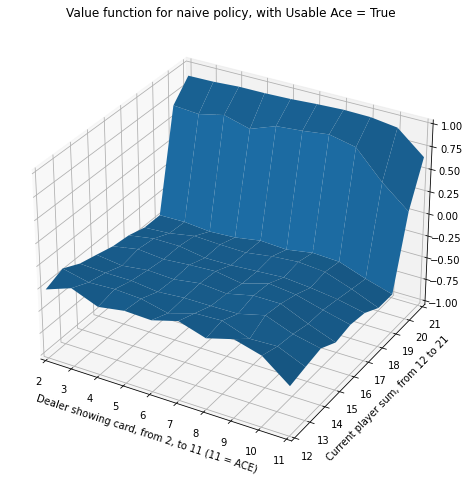

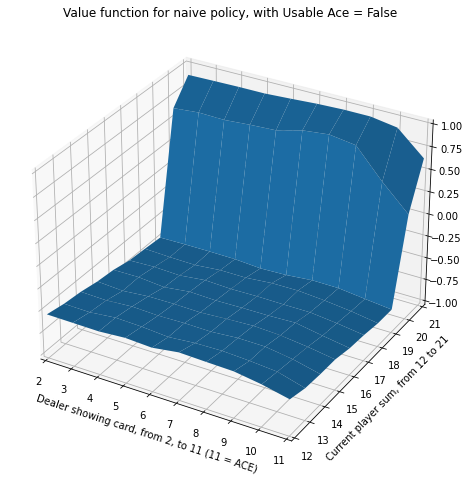

In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

X = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #Dealer showing card
Y = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21] #Player sum
X_mesh,Y_mesh = np.meshgrid(X,Y)

for ACE in [True, False]:
    Z_mesh = np.array([[V[codify_state(y, x, ACE)] for x in X] for y in Y])



    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.xticks(X)
    plt.yticks(Y)
    ax.set_zlim([-1, +1])
    ax.set_ylim([12, 21])
    ax.set_xlim([2, 11])


    plt.ylabel('Current player sum, from 12 to 21')
    plt.xlabel('Dealer showing card, from 2, to 11 (11 = ACE)')
    plt.title('Value function for naive policy, with Usable Ace = {}'.format(ACE))
    ax.plot_surface(X_mesh, Y_mesh, Z_mesh)

    fig.show()


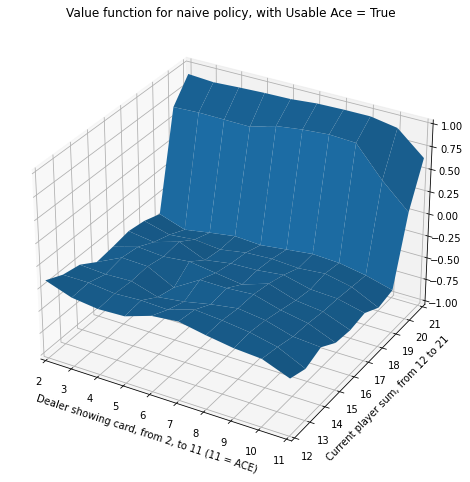

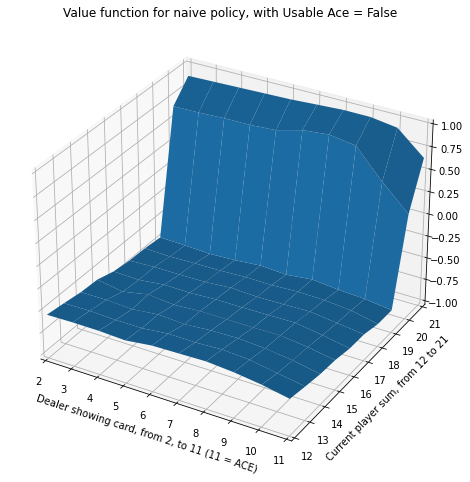

In [5]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

X = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #Dealer showing card
Y = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21] #Player sum
X_mesh,Y_mesh = np.meshgrid(X,Y)

for ACE in [True, False]:
    Z_mesh = np.array([[V[codify_state(y, x, ACE)] for x in X] for y in Y])



    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.xticks(X)
    plt.yticks(Y)
    ax.set_zlim([-1, +1])
    ax.set_ylim([12, 21])
    ax.set_xlim([2, 11])


    plt.ylabel('Current player sum, from 12 to 21')
    plt.xlabel('Dealer showing card, from 2, to 11 (11 = ACE)')
    plt.title('Value function for naive policy, with Usable Ace = {}'.format(ACE))
    ax.plot_surface(X_mesh, Y_mesh, Z_mesh)

    fig.show()
